In [4]:
%matplotlib inline
%cd /home/wallar/projects/nyc-taxi-analysis/

/home/wallar/projects/nyc-taxi-analysis


In [579]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scripts.plotting import plot_manhattan
from itertools import product
sns.set_context("paper", font_scale=2)

In [255]:
n_stations = 101

def load_data(p_st, d_st):
    fname = "data/ts/{}-{}.txt".format(p_st, d_st)
    df_options = {"names": ["datetime"],
                  "parse_dates": ["datetime"],
                  "infer_datetime_format": True,
                  "header": None,
                  "squeeze": True,
                  "skip_blank_lines": True,
                  "index_col": 0}
    df = pd.read_csv(fname, **df_options)
    df.sort_index(inplace=True)
    return df


def load_all_ts():
    prod = product(xrange(n_stations), xrange(n_stations))
    rng = tqdm.tqdm_notebook(prod, total=n_stations ** 2)
    mat = np.zeros((n_stations, n_stations), dtype=pd.DataFrame)
    for i, j in rng:
        try:
            mat[i, j] = load_data(i, j)
        except IOError:
            pass
    return mat


def get_sk_data(mat, p_st, d_st, start, n_days):
    prod = product(xrange(n_days), xrange(n_stations), xrange(n_stations))
    rng = tqdm.tqdm_notebook(prod, total=n_stations * n_stations * n_days)
    X = np.zeros((n_days, n_stations ** 2))
    Y = np.zeros((n_days,))
    day_1 = pd.Timedelta("1 day")
    dt = pd.Timedelta("30 min")
    for d, i, j in rng:
        try:
            st = start + d * day_1
            x = len(mat[i, j][st:st + dt])
            X[d, n_stations * i + j] = x
        except TypeError:
            pass
    for d in xrange(n_days):
        st = start + d * day_1
        y = len(mat[p_st, d_st][st + dt:st + 2 * dt])
        Y[d] = y
    return X, Y


def compute_coeffs(mat):
    prod = product(xrange(n_stations), xrange(n_stations))
    rng = tqdm.tqdm_notebook(prod, total=n_stations * n_stations)
    coeffs = np.zeros((n_stations, n_stations))
    for i, j in rng:
        try:
            coeffs[i, j] = len(mat[i, j])
        except TypeError:
            pass
    coeffs = coeffs / float(coeffs.max())
    return coeffs

In [380]:
coeffs = compute_coeffs(mat)

In [560]:
stations = pd.read_csv("data/stations.csv").as_matrix(["lng", "lat"])

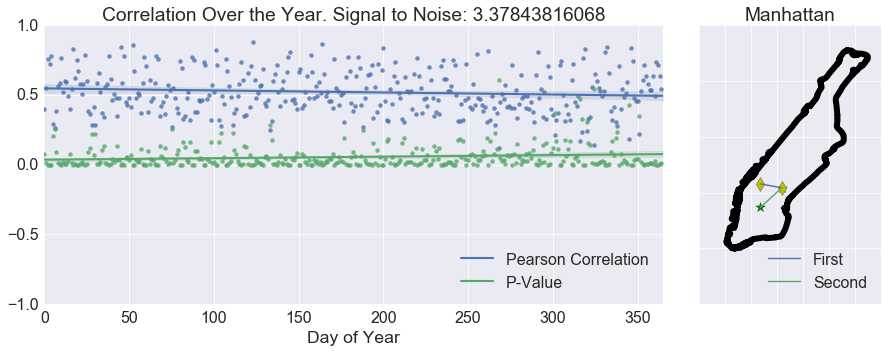

In [652]:
import scipy.stats as stats

cors = np.zeros((365,))
ps = np.zeros((365,))
ps0, ds0 = 42, 22
ps1, ds1 = 21, 42
for i in xrange(365):
    dt = pd.Timedelta("1 day")
    st = pd.Timestamp("2014-01-01 00:00") + i * dt
    ed = st + dt
    d1 = mat[ps0, ds0][st:ed].index.astype(np.int64)
    d2 = mat[ps1, ds1][st:ed].index.astype(np.int64)
    ts1, _ = np.histogram(d1, bins=20)
    ts2, _ = np.histogram(d2, bins=20)
    cors[i], ps[i] = stats.pearsonr(ts1, ts2)

#fig, axs = plt.subplots(1, 2, figsize=(17, 7))
#ax = axs[0]
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot2grid((1, 4), (0, 0), colspan=3)
sns.regplot(np.arange(365), cors, ax=ax)
sns.regplot(np.arange(365), ps, ax=ax)
stn = stats.signaltonoise(cors)
ax.set_title("Correlation Over the Year. Signal to Noise: {}".format(stn))
ax.set_xlabel("Day of Year")
ax.set_ylim(-1, 1)
ax.set_xlim(0, 365)
ax.legend(["Pearson Correlation", "P-Value"], loc="lower right")

#ax = axs[1]
ax = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax.plot(stations[[ps0, ds0], 0], stations[[ps0, ds0], 1])
ax.plot(stations[[ps1, ds1], 0], stations[[ps1, ds1], 1])
ax.scatter(stations[[ps0, ps1], 0], stations[[ps0, ps1], 1], c="g", marker="*", s=100)
ax.scatter(stations[[ds0, ds1], 0], stations[[ds0, ds1], 1], c="y", marker="d", s=100)
ax.legend(["First", "Second"], loc="lower right")
ax.set_xticklabels("")
ax.set_yticklabels("")
ax.set_title("Manhattan")
plot_manhattan(ax)
ax.relim()
ax.autoscale_view()